In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 10

In [5]:
seed = 3121
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  W9TG7ZON_05_36_32
NN-MODEL FILENAME:  ./models/W9TG7ZON_05_36_32_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [11]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 15000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = int(node_id%2)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1236.88 MiB, increment: 1016.81 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table

Process ForkPoolWorker-11:
Process ForkPoolWorker-10:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstra



ITERATION # 0
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 21529 EXPERIENCES:0:00:00.831886


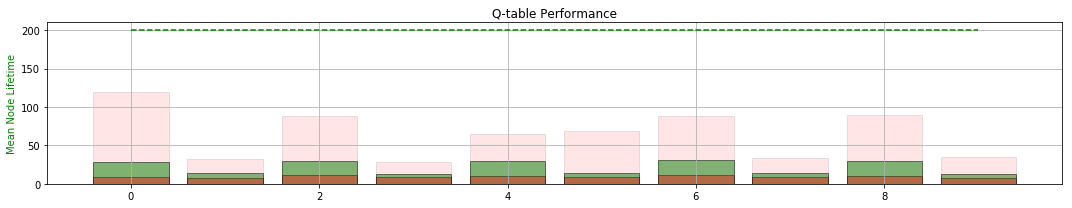

MEMORY COUNTER:  21529
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 5.592	LOSS : 5.278	LOSS : 5.296	LOSS : 5.823	LOSS : 4.596	LOSS : 4.946	LOSS : 5.842	LOSS : 4.870	LOSS : 5.264	LOSS : 5.331	LOSS : 4.478	LOSS : 5.203	LOSS : 5.275	LOSS : 5.173	LOSS : 5.043	LOSS : 5.056	LOSS : 5.083	LOSS : 4.893	LOSS : 5.310	LOSS : 4.941	LOSS : 4.562	LOSS : 4.337	LOSS : 5.225	LOSS : 4.626	LOSS : 4.154	LOSS : 4.614	LOSS : 4.852	LOSS : 4.843	LOSS : 4.778	LOSS : 4.669	
Validating... MEAN TIME:  195.305
LOSS : 4.430	LOSS : 4.338	LOSS : 3.983	LOSS : 4.412	LOSS : 4.520	LOSS : 4.338	LOSS : 3.987	LOSS : 4.752	LOSS : 4.177	LOSS : 4.370	LOSS : 4.616	LOSS : 4.570	LOSS : 4.508	LOSS : 4.549	LOSS : 4.592	LOSS : 3.914	LOSS : 4.473	LOSS : 4.442	LOSS : 4.235	LOSS : 4.296	LOSS : 3.961	LOSS : 4.103	LOSS : 4.415	LOSS : 4.322	LOSS : 4.697	LOSS : 4.466	LOSS : 4.054	LOSS : 3.989	LOSS : 4.218	LOSS : 4.627	
Validating... MEAN TIME:  186.915
LOSS : 4.330	LOSS : 4

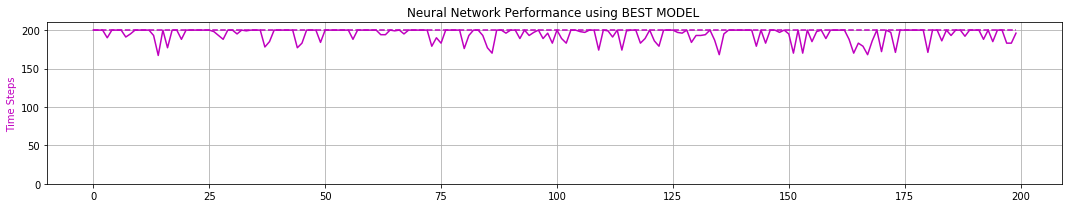

peak memory: 1384.69 MiB, increment: 1072.33 MiB
0 -max- [ 0.136  1.004  0.209  2.535]
0 -min- [-0.818 -1.970 -0.209 -2.095]

1 -max- [ 0.228  1.610  0.050  0.298]
1 -min- [-0.050 -0.178 -0.209 -2.481]

2 -max- [ 0.137  0.808  0.209  2.366]
2 -min- [-0.485 -1.944 -0.209 -1.839]

3 -max- [ 0.196  1.736  0.049  0.324]
3 -min- [-0.048 -0.204 -0.209 -2.699]

4 -max- [ 0.116  0.831  0.209  2.344]
4 -min- [-0.479 -1.951 -0.209 -1.787]

5 -max- [ 0.263  1.741  0.203  1.166]
5 -min- [-0.050 -0.560 -0.209 -2.712]

6 -max- [ 0.118  0.829  0.209  2.229]
6 -min- [-0.339 -1.906 -0.209 -2.013]

7 -max- [ 0.242  1.559  0.050  0.382]
7 -min- [-0.051 -0.219 -0.209 -2.527]

8 -max- [ 0.151  0.997  0.209  2.397]
8 -min- [-0.467 -1.736 -0.209 -1.797]

9 -max- [ 0.207  1.800  0.049  0.330]
9 -min- [-0.049 -0.192 -0.209 -2.766]

Quantization TIME:  0.01 minutes


ITERATION # 1
SMALLEST TIMESTEP in ITERATION 1: 8
REAL TIME TO GENERATE 91419 EXPERIENCES:0:00:03.229501


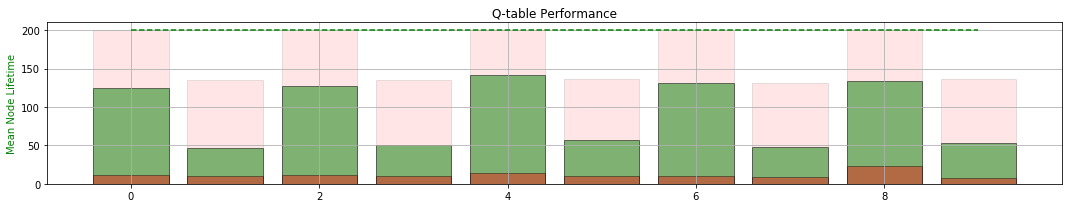

MEMORY COUNTER:  112948
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 4.396	LOSS : 3.537	LOSS : 3.228	LOSS : 2.868	LOSS : 2.716	LOSS : 2.692	LOSS : 2.695	LOSS : 3.114	LOSS : 2.950	LOSS : 2.905	LOSS : 2.456	LOSS : 2.579	LOSS : 2.283	LOSS : 2.688	LOSS : 2.711	LOSS : 2.796	LOSS : 2.821	LOSS : 2.702	LOSS : 2.867	LOSS : 2.639	LOSS : 2.529	LOSS : 2.747	LOSS : 2.517	LOSS : 2.627	LOSS : 2.531	LOSS : 2.826	LOSS : 2.399	LOSS : 2.486	LOSS : 2.312	LOSS : 2.433	
Validating... MEAN TIME:  171.59
LOSS : 2.377	LOSS : 2.309	LOSS : 2.779	LOSS : 2.215	LOSS : 2.214	LOSS : 2.605	LOSS : 2.161	LOSS : 2.071	LOSS : 2.443	LOSS : 2.230	LOSS : 2.048	LOSS : 2.186	LOSS : 2.301	LOSS : 2.164	LOSS : 2.088	LOSS : 2.406	LOSS : 1.854	LOSS : 2.120	LOSS : 2.125	LOSS : 2.256	LOSS : 1.947	LOSS : 2.396	LOSS : 2.260	LOSS : 2.199	LOSS : 1.970	LOSS : 2.066	LOSS : 2.043	LOSS : 1.785	LOSS : 2.026	LOSS : 2.242	
Validating... MEAN TIME:  164.825
LOSS : 1.926	LOSS : 2

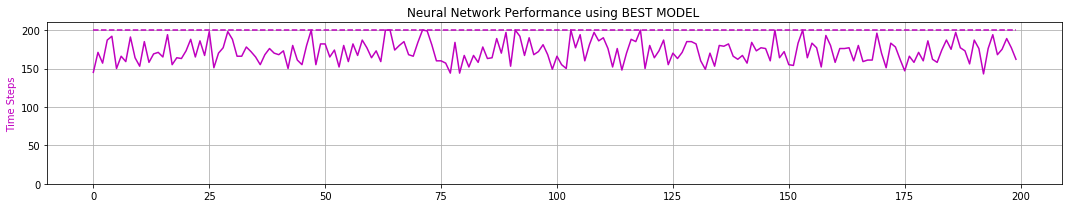

peak memory: 1416.42 MiB, increment: 1073.92 MiB
0 -max- [ 1.184  1.486  0.209  2.721]
0 -min- [-2.398 -2.769 -0.209 -2.006]

1 -max- [ 0.193  1.396  0.072  1.246]
1 -min- [-2.387 -2.427 -0.209 -2.216]

2 -max- [ 0.839  1.554  0.209  2.539]
2 -min- [-2.395 -2.806 -0.209 -2.475]

3 -max- [ 0.199  1.417  0.050  1.182]
3 -min- [-2.383 -2.614 -0.209 -2.245]

4 -max- [ 1.117  1.436  0.209  2.348]
4 -min- [-2.399 -2.992 -0.209 -2.417]

5 -max- [ 0.188  1.399  0.065  1.294]
5 -min- [-2.396 -2.583 -0.209 -2.267]

6 -max- [ 1.057  1.501  0.209  2.441]
6 -min- [-2.399 -2.783 -0.209 -2.706]

7 -max- [ 0.225  1.219  0.048  1.280]
7 -min- [-2.391 -2.571 -0.209 -2.020]

8 -max- [ 1.162  1.645  0.209  2.593]
8 -min- [-2.399 -2.779 -0.208 -2.259]

9 -max- [ 0.201  1.218  0.064  1.155]
9 -min- [-2.395 -2.566 -0.209 -2.247]

Quantization TIME:  0.01 minutes


ITERATION # 2
SMALLEST TIMESTEP in ITERATION 2: 10
REAL TIME TO GENERATE 110014 EXPERIENCES:0:00:03.043536


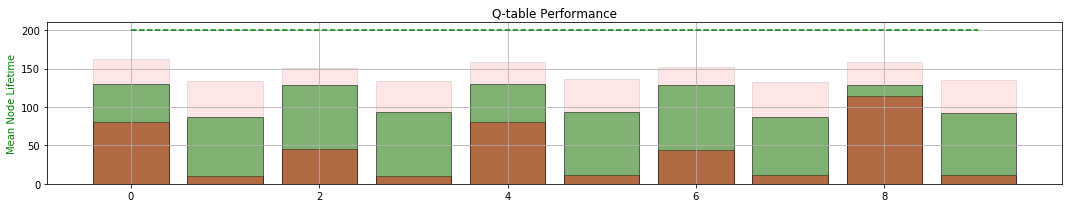

MEMORY COUNTER:  222962
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.238	LOSS : 1.331	LOSS : 1.389	LOSS : 1.996	LOSS : 1.607	LOSS : 1.321	LOSS : 1.641	LOSS : 1.268	LOSS : 1.314	LOSS : 1.691	LOSS : 1.614	LOSS : 1.612	LOSS : 1.135	LOSS : 1.558	LOSS : 1.321	LOSS : 1.584	LOSS : 1.647	LOSS : 1.658	LOSS : 1.426	LOSS : 1.248	LOSS : 1.532	LOSS : 1.513	LOSS : 1.317	LOSS : 1.404	LOSS : 1.537	LOSS : 1.173	LOSS : 1.543	LOSS : 1.593	LOSS : 1.522	LOSS : 1.134	
Validating... MEAN TIME:  151.76
LOSS : 1.293	LOSS : 1.348	LOSS : 1.608	LOSS : 1.585	LOSS : 1.152	LOSS : 1.243	LOSS : 1.443	LOSS : 1.568	LOSS : 1.800	LOSS : 1.033	LOSS : 1.401	LOSS : 1.177	LOSS : 1.845	LOSS : 1.522	LOSS : 1.341	LOSS : 1.425	LOSS : 1.761	LOSS : 1.572	LOSS : 1.478	LOSS : 1.618	LOSS : 1.464	LOSS : 1.360	LOSS : 1.751	LOSS : 1.630	LOSS : 1.536	LOSS : 1.413	LOSS : 1.565	LOSS : 1.455	LOSS : 1.527	LOSS : 1.823	
Validating... MEAN TIME:  184.805
LOSS : 1.564	LOSS : 1

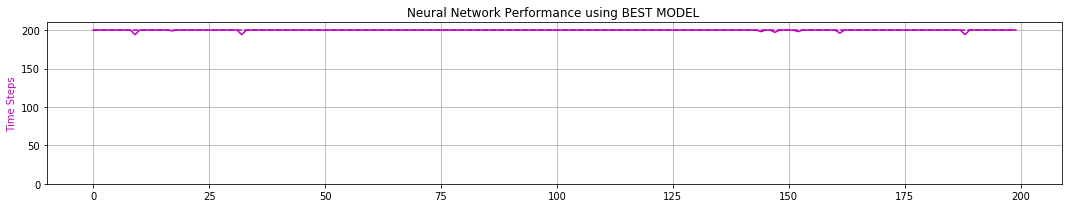

peak memory: 1419.55 MiB, increment: 1041.07 MiB
0 -max- [ 0.187  1.128  0.147  1.496]
0 -min- [-2.400 -2.942 -0.208 -1.697]

1 -max- [ 0.200  1.210  0.049  0.998]
1 -min- [-2.400 -2.791 -0.209 -1.980]

2 -max- [ 0.171  0.731  0.204  1.693]
2 -min- [-2.400 -2.950 -0.196 -1.617]

3 -max- [ 0.185  1.206  0.050  0.992]
3 -min- [-2.400 -2.773 -0.209 -1.910]

4 -max- [ 0.163  1.200  0.112  1.418]
4 -min- [-2.399 -2.773 -0.202 -1.593]

5 -max- [ 0.192  1.399  0.050  0.995]
5 -min- [-2.400 -2.733 -0.209 -2.110]

6 -max- [ 0.164  0.972  0.209  1.741]
6 -min- [-2.399 -2.921 -0.209 -1.592]

7 -max- [ 0.197  1.016  0.049  1.018]
7 -min- [-2.400 -2.790 -0.209 -1.629]

8 -max- [ 0.200  0.957  0.068  1.212]
8 -min- [-2.400 -2.791 -0.188 -1.352]

9 -max- [ 0.185  1.406  0.046  1.006]
9 -min- [-2.399 -2.766 -0.209 -2.132]

Quantization TIME:  0.01 minutes


ITERATION # 3
SMALLEST TIMESTEP in ITERATION 3: 11
REAL TIME TO GENERATE 158343 EXPERIENCES:0:00:04.244603


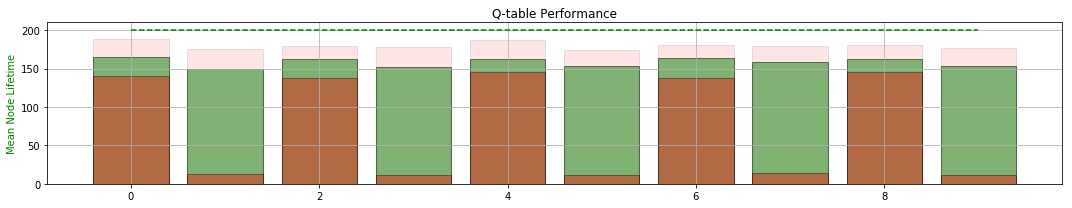

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.091	LOSS : 0.955	LOSS : 1.094	LOSS : 0.967	LOSS : 1.246	LOSS : 0.953	LOSS : 0.896	LOSS : 0.872	LOSS : 0.746	LOSS : 0.937	LOSS : 1.149	LOSS : 0.949	LOSS : 1.031	LOSS : 0.909	LOSS : 1.011	LOSS : 0.817	LOSS : 0.951	LOSS : 0.962	LOSS : 0.884	LOSS : 0.941	LOSS : 0.958	LOSS : 0.982	LOSS : 0.696	LOSS : 0.841	LOSS : 0.785	LOSS : 0.950	LOSS : 0.835	LOSS : 0.829	LOSS : 0.826	LOSS : 1.056	
Validating... MEAN TIME:  200.0
LOSS : 0.717	LOSS : 0.804	LOSS : 1.064	LOSS : 0.856	LOSS : 0.702	LOSS : 0.894	LOSS : 0.768	LOSS : 1.137	LOSS : 1.113	LOSS : 1.009	LOSS : 0.906	LOSS : 0.969	LOSS : 0.871	LOSS : 0.984	LOSS : 1.074	LOSS : 0.783	LOSS : 1.010	LOSS : 0.975	LOSS : 0.820	LOSS : 1.070	LOSS : 0.940	LOSS : 0.812	LOSS : 0.902	LOSS : 0.985	LOSS : 1.103	LOSS : 0.941	LOSS : 0.682	LOSS : 0.793	LOSS : 0.874	LOSS : 0.895	
Validating... MEAN TIME:  200.0
LOSS : 0.869	LOSS : 0.866

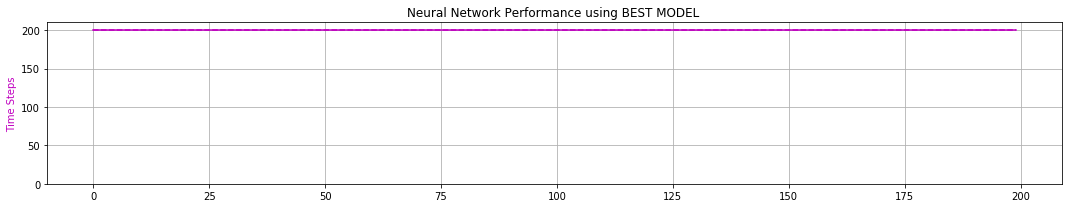

peak memory: 1447.76 MiB, increment: 979.27 MiB
0 -max- [ 0.172  1.173  0.128  1.880]
0 -min- [-2.014 -1.751 -0.209 -1.688]

1 -max- [ 0.201  1.209  0.075  1.636]
1 -min- [-2.028 -1.873 -0.209 -1.792]

2 -max- [ 0.175  1.205  0.090  1.579]
2 -min- [-2.022 -1.729 -0.209 -1.684]

3 -max- [ 0.190  1.215  0.085  1.573]
3 -min- [-2.145 -2.041 -0.209 -1.903]

4 -max- [ 0.193  1.215  0.099  1.614]
4 -min- [-2.034 -1.713 -0.209 -1.706]

5 -max- [ 0.188  1.211  0.069  1.629]
5 -min- [-1.997 -1.699 -0.209 -1.955]

6 -max- [ 0.195  1.198  0.094  1.613]
6 -min- [-2.010 -1.705 -0.209 -1.688]

7 -max- [ 0.196  1.162  0.074  1.570]
7 -min- [-2.007 -1.698 -0.209 -1.756]

8 -max- [ 0.189  1.174  0.097  1.559]
8 -min- [-1.950 -1.650 -0.209 -1.679]

9 -max- [ 0.189  1.214  0.069  1.624]
9 -min- [-1.913 -1.664 -0.209 -1.892]

Quantization TIME:  0.01 minutes


ITERATION # 4
SMALLEST TIMESTEP in ITERATION 4: 69
REAL TIME TO GENERATE 199869 EXPERIENCES:0:00:06.949057


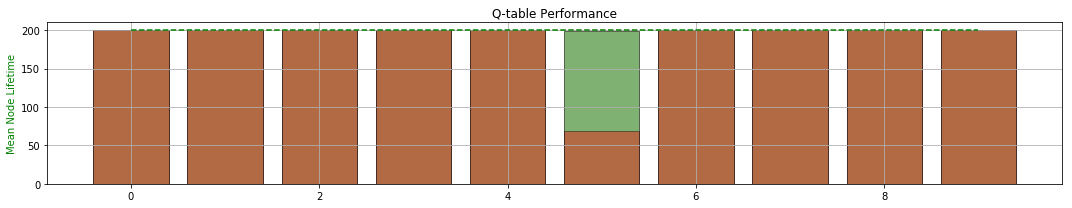

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.617	LOSS : 0.487	LOSS : 0.279	LOSS : 0.621	LOSS : 0.352	LOSS : 0.515	LOSS : 0.525	LOSS : 0.760	LOSS : 0.394	LOSS : 0.510	LOSS : 0.376	LOSS : 0.508	LOSS : 0.583	LOSS : 0.357	LOSS : 0.381	LOSS : 0.512	LOSS : 0.691	LOSS : 0.359	LOSS : 0.463	LOSS : 0.649	LOSS : 0.403	LOSS : 0.541	LOSS : 0.371	LOSS : 0.463	LOSS : 0.587	LOSS : 0.579	LOSS : 0.465	LOSS : 0.498	LOSS : 0.306	LOSS : 0.595	
Validating... MEAN TIME:  200.0
LOSS : 0.758	LOSS : 0.570	LOSS : 0.374	LOSS : 0.485	LOSS : 0.448	LOSS : 0.657	LOSS : 0.476	LOSS : 0.363	LOSS : 0.582	LOSS : 0.474	LOSS : 0.540	LOSS : 0.513	LOSS : 0.502	LOSS : 0.391	LOSS : 0.317	LOSS : 0.706	LOSS : 0.515	LOSS : 0.456	LOSS : 0.550	LOSS : 0.510	LOSS : 0.671	LOSS : 0.315	LOSS : 0.460	LOSS : 0.486	LOSS : 0.487	LOSS : 0.405	LOSS : 0.426	LOSS : 0.408	LOSS : 0.531	LOSS : 0.491	
Validating... MEAN TIME:  200.0
LOSS : 0.485	LOSS : 0.590

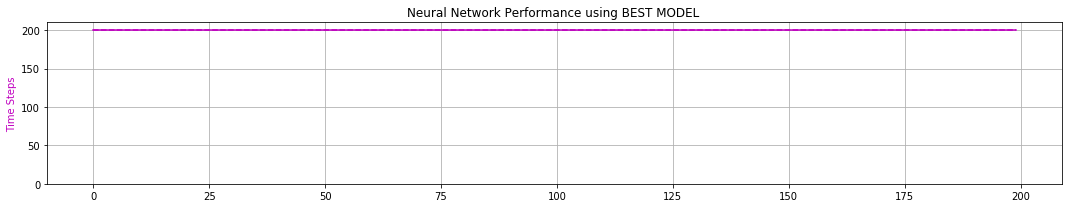

peak memory: 1488.66 MiB, increment: 1054.76 MiB
0 -max- [ 0.155  1.008  0.136  1.588]
0 -min- [-1.255 -1.372 -0.109 -1.463]

1 -max- [ 0.126  1.020  0.090  1.850]
1 -min- [-1.556 -1.685 -0.175 -1.660]

2 -max- [ 0.189  1.179  0.129  1.751]
2 -min- [-1.226 -1.335 -0.151 -1.673]

3 -max- [ 0.193  1.205  0.078  1.580]
3 -min- [-1.529 -1.494 -0.170 -1.678]

4 -max- [ 0.155  1.016  0.163  1.576]
4 -min- [-1.320 -1.322 -0.126 -1.424]

5 -max- [ 0.175  1.020  0.085  1.651]
5 -min- [-1.658 -1.518 -0.209 -1.677]

6 -max- [ 0.191  1.162  0.132  1.610]
6 -min- [-1.297 -1.352 -0.174 -1.648]

7 -max- [ 0.185  1.153  0.095  1.643]
7 -min- [-1.590 -1.548 -0.162 -1.677]

8 -max- [ 0.137  0.953  0.120  1.630]
8 -min- [-1.316 -1.349 -0.122 -1.389]

9 -max- [ 0.160  1.016  0.082  1.590]
9 -min- [-1.316 -1.350 -0.149 -1.407]

Quantization TIME:  0.01 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 9
REAL TIME TO GENERATE 186375 EXPERIENCES:0:00:05.673133


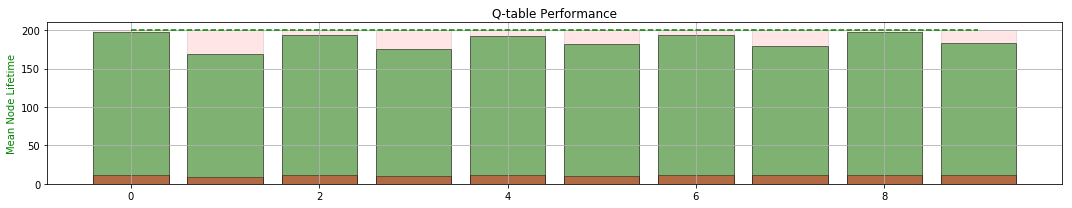

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.627	LOSS : 0.680	LOSS : 0.492	LOSS : 0.465	LOSS : 0.629	LOSS : 0.613	LOSS : 0.385	LOSS : 0.540	LOSS : 0.690	LOSS : 0.560	LOSS : 0.789	LOSS : 0.733	LOSS : 0.419	LOSS : 0.692	LOSS : 0.383	LOSS : 0.551	LOSS : 0.576	LOSS : 0.638	LOSS : 0.497	LOSS : 0.438	LOSS : 0.390	LOSS : 0.604	LOSS : 0.476	LOSS : 0.456	LOSS : 0.445	LOSS : 0.474	LOSS : 0.326	LOSS : 0.465	LOSS : 0.682	LOSS : 0.384	
Validating... MEAN TIME:  194.28
LOSS : 0.464	LOSS : 0.421	LOSS : 0.532	LOSS : 0.545	LOSS : 0.325	LOSS : 0.800	LOSS : 0.458	LOSS : 0.455	LOSS : 0.493	LOSS : 0.513	LOSS : 0.541	LOSS : 0.572	LOSS : 0.591	LOSS : 0.441	LOSS : 0.543	LOSS : 0.706	LOSS : 0.591	LOSS : 0.537	LOSS : 0.460	LOSS : 0.529	LOSS : 0.617	LOSS : 0.669	LOSS : 0.479	LOSS : 0.391	LOSS : 0.486	LOSS : 0.664	LOSS : 0.496	LOSS : 0.528	LOSS : 0.483	LOSS : 0.305	
Validating... MEAN TIME:  154.68
LOSS : 0.657	LOSS : 0.3

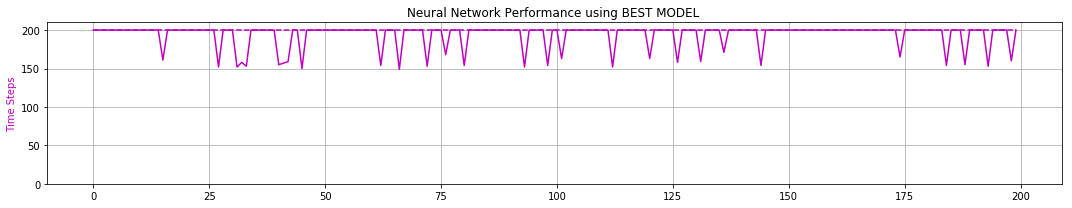

peak memory: 1529.59 MiB, increment: 1017.84 MiB
0 -max- [ 0.175  1.401  0.141  1.768]
0 -min- [-2.399 -2.027 -0.195 -1.961]

1 -max- [ 0.190  1.411  0.099  1.804]
1 -min- [-2.400 -2.050 -0.209 -1.995]

2 -max- [ 0.218  1.410  0.119  1.717]
2 -min- [-2.399 -1.870 -0.209 -1.982]

3 -max- [ 0.194  1.385  0.097  1.939]
3 -min- [-2.396 -2.253 -0.209 -2.072]

4 -max- [ 0.195  1.394  0.144  1.802]
4 -min- [-2.318 -2.034 -0.200 -1.994]

5 -max- [ 0.211  1.358  0.102  1.871]
5 -min- [-2.398 -2.262 -0.209 -1.993]

6 -max- [ 0.189  1.393  0.167  1.721]
6 -min- [-2.395 -1.913 -0.198 -1.991]

7 -max- [ 0.194  1.408  0.095  1.951]
7 -min- [-2.400 -2.297 -0.207 -1.989]

8 -max- [ 0.184  1.370  0.143  1.825]
8 -min- [-2.400 -2.050 -0.196 -1.964]

9 -max- [ 0.190  1.399  0.098  1.834]
9 -min- [-2.398 -2.106 -0.209 -1.986]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 30
REAL TIME TO GENERATE 192459 EXPERIENCES:0:00:06.263781


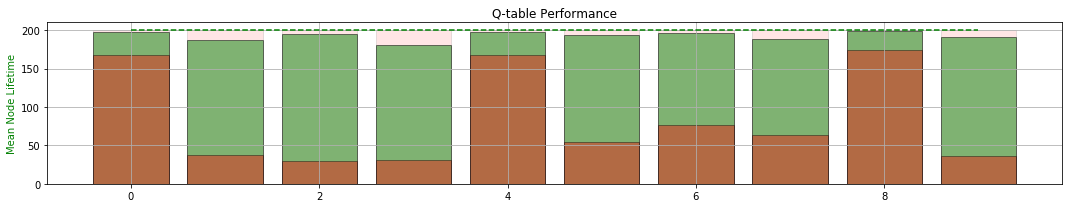

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.987	LOSS : 0.729	LOSS : 0.661	LOSS : 0.554	LOSS : 0.534	LOSS : 0.486	LOSS : 0.628	LOSS : 0.572	LOSS : 0.472	LOSS : 0.598	LOSS : 0.604	LOSS : 0.384	LOSS : 0.576	LOSS : 0.584	LOSS : 0.496	LOSS : 0.382	LOSS : 0.524	LOSS : 0.183	LOSS : 0.758	LOSS : 0.782	LOSS : 0.152	LOSS : 0.642	LOSS : 0.610	LOSS : 0.594	LOSS : 0.350	LOSS : 0.486	LOSS : 0.472	LOSS : 0.576	LOSS : 0.596	LOSS : 0.612	
Validating... MEAN TIME:  154.19
LOSS : 0.523	LOSS : 0.319	LOSS : 0.380	LOSS : 0.782	LOSS : 0.820	LOSS : 0.491	LOSS : 0.395	LOSS : 0.366	LOSS : 0.459	LOSS : 0.518	LOSS : 0.668	LOSS : 0.514	LOSS : 0.495	LOSS : 0.421	LOSS : 0.391	LOSS : 0.440	LOSS : 0.631	LOSS : 0.430	LOSS : 0.319	LOSS : 0.361	LOSS : 0.381	LOSS : 0.709	LOSS : 0.606	LOSS : 0.644	LOSS : 0.607	LOSS : 0.536	LOSS : 0.366	LOSS : 0.535	LOSS : 0.715	LOSS : 0.480	
Validating... MEAN TIME:  155.575
LOSS : 0.548	LOSS : 0.

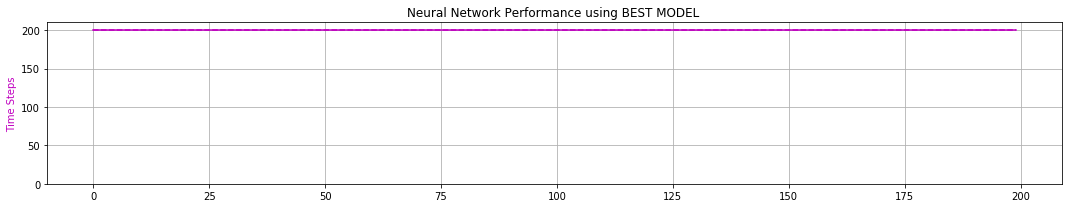

peak memory: 1453.25 MiB, increment: 976.23 MiB
0 -max- [ 0.403  1.731  0.185  1.877]
0 -min- [-2.398 -2.300 -0.199 -2.185]

1 -max- [ 0.406  1.689  0.110  1.935]
1 -min- [-2.400 -2.116 -0.208 -2.145]

2 -max- [ 0.410  1.734  0.183  1.922]
2 -min- [-2.399 -2.443 -0.208 -2.116]

3 -max- [ 0.397  1.549  0.160  2.159]
3 -min- [-2.400 -2.813 -0.209 -1.944]

4 -max- [ 0.429  1.715  0.153  2.018]
4 -min- [-2.396 -2.305 -0.194 -1.955]

5 -max- [ 0.399  1.550  0.196  2.251]
5 -min- [-2.399 -2.697 -0.209 -1.982]

6 -max- [ 0.431  1.751  0.182  1.934]
6 -min- [-2.399 -2.429 -0.208 -2.056]

7 -max- [ 0.391  1.543  0.170  2.219]
7 -min- [-2.400 -2.668 -0.209 -1.929]

8 -max- [ 0.384  1.784  0.174  2.197]
8 -min- [-2.395 -2.281 -0.209 -2.148]

9 -max- [ 0.392  1.714  0.155  2.163]
9 -min- [-2.398 -2.642 -0.208 -2.244]

Quantization TIME:  0.01 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 76
REAL TIME TO GENERATE 196998 EXPERIENCES:0:00:06.678814


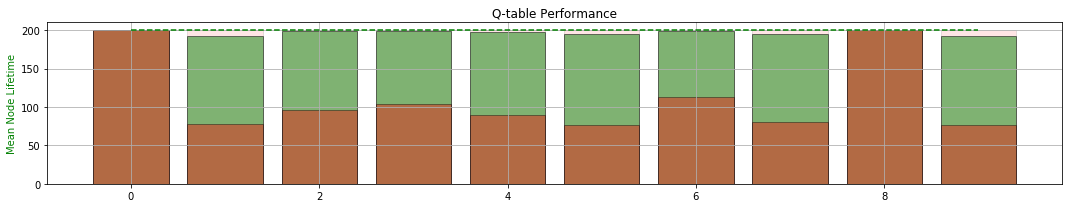

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.191	LOSS : 0.873	LOSS : 0.820	LOSS : 0.625	LOSS : 0.496	LOSS : 0.506	LOSS : 0.286	LOSS : 0.384	LOSS : 0.527	LOSS : 0.554	LOSS : 0.626	LOSS : 0.364	LOSS : 0.531	LOSS : 0.547	LOSS : 0.635	LOSS : 0.383	LOSS : 0.509	LOSS : 0.386	LOSS : 0.422	LOSS : 0.448	LOSS : 0.533	LOSS : 0.468	LOSS : 0.544	LOSS : 0.285	LOSS : 0.608	LOSS : 0.431	LOSS : 0.501	LOSS : 0.511	LOSS : 0.462	LOSS : 0.296	
Validating... MEAN TIME:  117.74
LOSS : 0.380	LOSS : 0.535	LOSS : 0.551	LOSS : 0.382	LOSS : 0.333	LOSS : 0.389	LOSS : 0.550	LOSS : 0.623	LOSS : 0.399	LOSS : 0.464	LOSS : 0.568	LOSS : 0.473	LOSS : 0.587	LOSS : 0.580	LOSS : 0.487	LOSS : 0.391	LOSS : 0.605	LOSS : 0.378	LOSS : 0.609	LOSS : 0.436	LOSS : 0.389	LOSS : 0.297	LOSS : 0.374	LOSS : 0.294	LOSS : 0.309	LOSS : 0.529	LOSS : 0.639	LOSS : 0.613	LOSS : 0.360	LOSS : 0.345	
Validating... MEAN TIME:  120.38
LOSS : 0.470	LOSS : 0.4

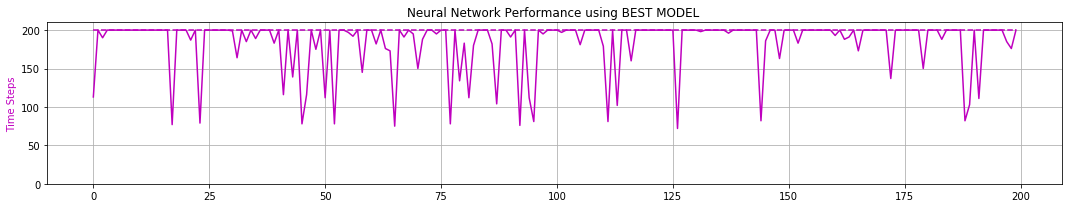

peak memory: 1529.66 MiB, increment: 1017.17 MiB
0 -max- [ 1.285  1.937  0.193  1.950]
0 -min- [-0.498 -1.625 -0.168 -1.932]

1 -max- [ 0.902  1.959  0.132  1.953]
1 -min- [-0.728 -2.209 -0.205 -2.326]

2 -max- [ 1.307  1.894  0.204  1.929]
2 -min- [-0.450 -1.842 -0.168 -1.859]

3 -max- [ 0.872  1.737  0.132  1.953]
3 -min- [-1.003 -2.215 -0.202 -1.850]

4 -max- [ 1.236  2.053  0.207  1.956]
4 -min- [-0.457 -1.832 -0.171 -1.950]

5 -max- [ 0.861  1.680  0.133  2.115]
5 -min- [-0.695 -2.200 -0.209 -1.781]

6 -max- [ 0.998  1.886  0.199  1.937]
6 -min- [-0.633 -2.039 -0.171 -1.869]

7 -max- [ 0.874  1.718  0.135  2.000]
7 -min- [-0.822 -2.100 -0.205 -1.904]

8 -max- [ 0.996  1.713  0.145  1.956]
8 -min- [-0.453 -2.197 -0.171 -1.828]

9 -max- [ 0.866  1.770  0.119  1.973]
9 -min- [-1.161 -2.215 -0.208 -1.973]

Quantization TIME:  0.01 minutes


ITERATION # 8
SMALLEST TIMESTEP in ITERATION 8: 69
REAL TIME TO GENERATE 173780 EXPERIENCES:0:00:05.083507


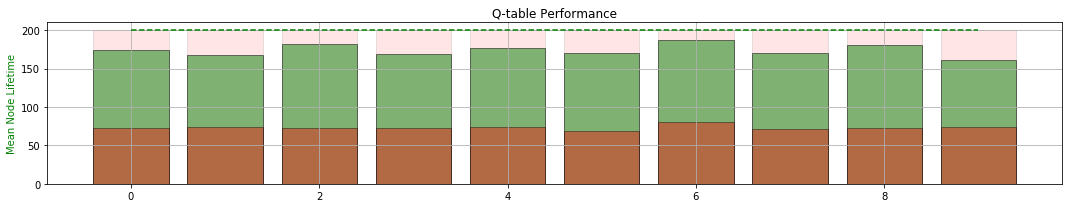

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.944	LOSS : 0.576	LOSS : 0.635	LOSS : 0.657	LOSS : 0.488	LOSS : 0.603	LOSS : 0.530	LOSS : 0.682	LOSS : 0.618	LOSS : 0.708	LOSS : 0.550	LOSS : 0.543	LOSS : 0.634	LOSS : 0.531	LOSS : 0.575	LOSS : 0.565	LOSS : 0.425	LOSS : 0.530	LOSS : 0.551	LOSS : 0.402	LOSS : 0.407	LOSS : 0.760	LOSS : 0.612	LOSS : 0.450	LOSS : 0.569	LOSS : 0.635	LOSS : 0.583	LOSS : 0.463	LOSS : 0.611	LOSS : 0.633	
Validating... MEAN TIME:  15.83
LOSS : 0.385	LOSS : 0.772	LOSS : 0.569	LOSS : 0.662	LOSS : 0.591	LOSS : 0.381	LOSS : 0.509	LOSS : 0.525	LOSS : 0.435	LOSS : 0.416	LOSS : 0.255	LOSS : 0.557	LOSS : 0.459	LOSS : 0.399	LOSS : 0.465	LOSS : 0.469	LOSS : 0.488	LOSS : 0.576	LOSS : 0.574	LOSS : 0.422	LOSS : 0.538	LOSS : 0.432	LOSS : 0.467	LOSS : 0.477	LOSS : 0.544	LOSS : 0.537	LOSS : 0.591	LOSS : 0.497	LOSS : 0.299	LOSS : 0.638	
Validating... MEAN TIME:  16.51
LOSS : 0.578	LOSS : 0.634

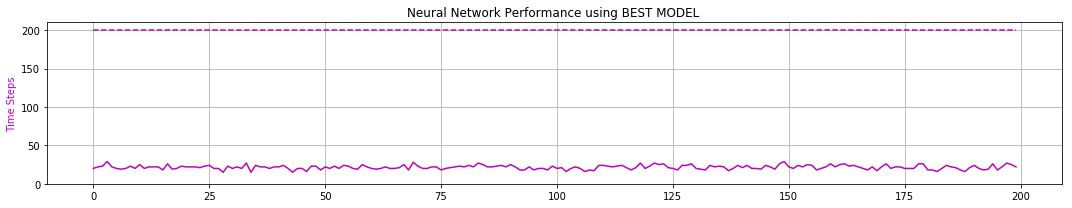

peak memory: 1443.77 MiB, increment: 978.41 MiB
0 -max- [ 1.307  2.324  0.209  2.312]
0 -min- [-0.122 -2.479 -0.209 -2.267]

1 -max- [ 1.184  2.313  0.208  2.200]
1 -min- [-0.106 -2.444 -0.209 -2.361]

2 -max- [ 1.214  2.430  0.208  2.242]
2 -min- [-0.125 -2.470 -0.209 -2.238]

3 -max- [ 1.185  2.315  0.208  2.222]
3 -min- [-0.097 -2.829 -0.209 -2.307]

4 -max- [ 1.205  2.312  0.209  2.213]
4 -min- [-0.148 -2.438 -0.209 -2.157]

5 -max- [ 1.191  2.285  0.209  2.252]
5 -min- [-0.112 -2.479 -0.209 -2.283]

6 -max- [ 1.298  2.311  0.209  2.226]
6 -min- [-0.118 -2.455 -0.209 -2.235]

7 -max- [ 1.178  2.138  0.209  1.972]
7 -min- [-0.125 -2.276 -0.209 -2.226]

8 -max- [ 1.309  2.486  0.209  2.208]
8 -min- [-0.153 -2.415 -0.209 -2.272]

9 -max- [ 1.185  2.306  0.209  2.245]
9 -min- [-0.145 -2.458 -0.209 -2.295]

Quantization TIME:  0.01 minutes


ITERATION # 9
SMALLEST TIMESTEP in ITERATION 9: 21
REAL TIME TO GENERATE 59442 EXPERIENCES:0:00:01.456188


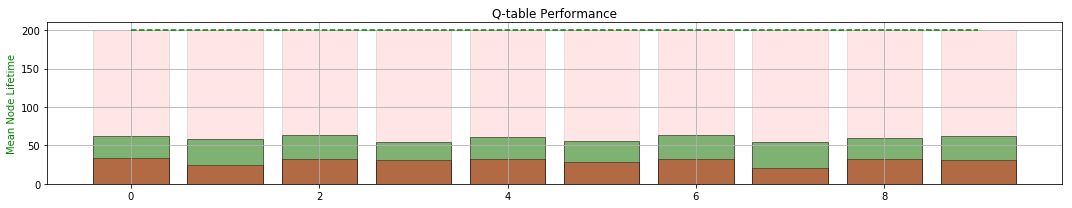

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.065	LOSS : 0.924	LOSS : 1.084	LOSS : 0.772	LOSS : 0.812	LOSS : 0.680	LOSS : 0.816	LOSS : 1.130	LOSS : 0.719	LOSS : 0.935	LOSS : 0.868	LOSS : 0.920	LOSS : 0.888	LOSS : 0.719	LOSS : 0.698	LOSS : 0.756	LOSS : 0.578	LOSS : 0.523	LOSS : 0.852	LOSS : 0.602	LOSS : 0.802	LOSS : 0.846	LOSS : 0.933	LOSS : 0.758	LOSS : 0.898	LOSS : 0.925	LOSS : 0.921	LOSS : 0.550	LOSS : 0.860	LOSS : 0.930	
Validating... MEAN TIME:  200.0
LOSS : 0.822	LOSS : 0.650	LOSS : 0.652	LOSS : 0.764	LOSS : 0.820	LOSS : 0.919	LOSS : 0.635	LOSS : 0.817	LOSS : 0.694	LOSS : 0.628	LOSS : 0.918	LOSS : 0.959	LOSS : 0.825	LOSS : 0.678	LOSS : 0.637	LOSS : 0.602	LOSS : 0.755	LOSS : 0.852	LOSS : 0.761	LOSS : 0.539	LOSS : 0.755	LOSS : 0.738	LOSS : 0.931	LOSS : 0.873	LOSS : 0.794	LOSS : 0.771	LOSS : 0.803	LOSS : 0.882	LOSS : 0.977	LOSS : 0.733	
Validating... MEAN TIME:  199.91
LOSS : 0.655	LOSS : 0.93

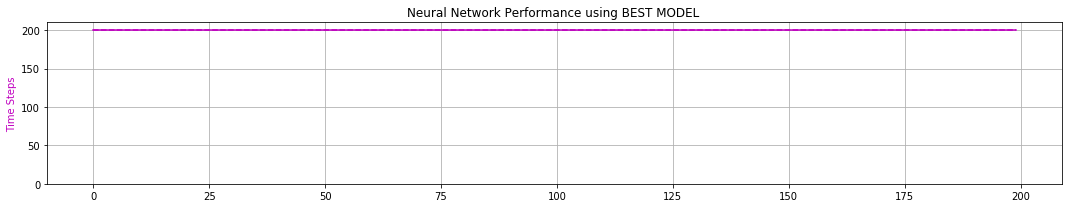

peak memory: 1492.47 MiB, increment: 978.29 MiB
0 -max- [ 1.927  2.454  0.139  0.958]
0 -min- [-0.232 -1.285 -0.209 -1.729]

1 -max- [ 1.880  2.594  0.135  0.964]
1 -min- [-2.382 -2.067 -0.209 -1.962]

2 -max- [ 1.913  2.634  0.141  0.927]
2 -min- [-0.223 -1.104 -0.209 -1.886]

3 -max- [ 1.922  2.677  0.124  0.836]
3 -min- [-0.202 -1.084 -0.209 -1.968]

4 -max- [ 1.926  2.682  0.131  0.860]
4 -min- [-0.279 -1.121 -0.209 -1.930]

5 -max- [ 1.891  2.668  0.137  1.148]
5 -min- [-2.394 -2.082 -0.209 -1.900]

6 -max- [ 1.925  2.677  0.139  0.960]
6 -min- [-2.373 -2.410 -0.209 -1.958]

7 -max- [ 1.937  2.675  0.122  1.056]
7 -min- [-0.215 -0.996 -0.209 -1.908]

8 -max- [ 2.039  2.448  0.162  1.020]
8 -min- [-0.203 -0.991 -0.209 -1.666]

9 -max- [ 1.915  2.646  0.138  0.934]
9 -min- [-0.252 -1.303 -0.209 -1.883]

Quantization TIME:  0.01 minutes


ITERATION # 10
SMALLEST TIMESTEP in ITERATION 10: 158
REAL TIME TO GENERATE 181873 EXPERIENCES:0:00:05.487716


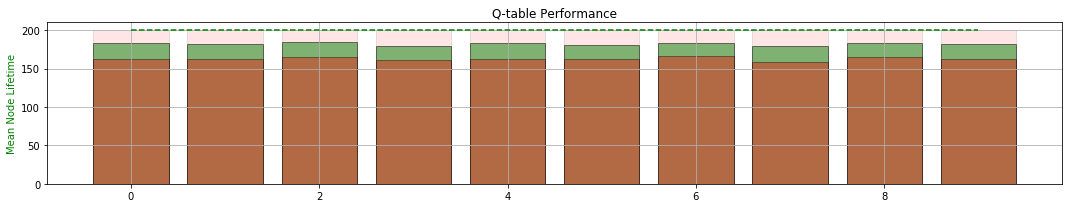

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.266	LOSS : 0.757	LOSS : 1.016	LOSS : 0.772	LOSS : 0.981	LOSS : 1.032	LOSS : 0.863	LOSS : 0.815	LOSS : 0.987	LOSS : 0.865	LOSS : 0.778	LOSS : 0.940	LOSS : 1.093	LOSS : 0.631	LOSS : 0.991	LOSS : 0.897	LOSS : 0.836	LOSS : 1.019	LOSS : 0.845	LOSS : 0.937	LOSS : 0.753	LOSS : 0.849	LOSS : 1.074	LOSS : 0.769	LOSS : 0.955	LOSS : 0.754	LOSS : 0.700	LOSS : 0.675	LOSS : 0.866	LOSS : 0.652	
Validating... MEAN TIME:  129.485
LOSS : 0.803	LOSS : 0.780	LOSS : 0.707	LOSS : 0.675	LOSS : 0.985	LOSS : 0.888	LOSS : 1.004	LOSS : 0.666	LOSS : 0.860	LOSS : 0.760	LOSS : 0.943	LOSS : 0.830	LOSS : 0.909	LOSS : 0.873	LOSS : 0.622	LOSS : 0.679	LOSS : 0.702	LOSS : 1.112	LOSS : 0.879	LOSS : 0.663	LOSS : 0.891	LOSS : 0.841	LOSS : 0.686	LOSS : 0.804	LOSS : 0.795	LOSS : 0.724	LOSS : 0.897	LOSS : 0.674	LOSS : 0.642	LOSS : 0.771	
Validating... MEAN TIME:  131.13
LOSS : 0.900	LOSS : 0.

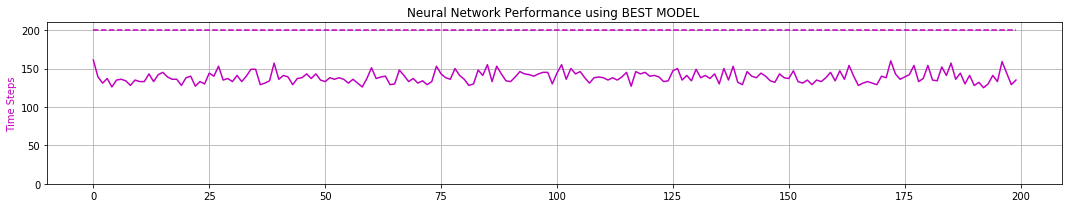

peak memory: 1492.47 MiB, increment: 976.52 MiB
0 -max- [ 2.363  2.458  0.165  1.835]
0 -min- [-2.399 -1.891 -0.112 -1.480]

1 -max- [ 0.153  0.600  0.046  0.938]
1 -min- [-2.400 -1.891 -0.139 -1.053]

2 -max- [ 2.388  2.650  0.185  1.765]
2 -min- [-2.399 -1.895 -0.121 -1.399]

3 -max- [ 1.988  2.294  0.144  1.782]
3 -min- [-2.400 -1.894 -0.134 -1.511]

4 -max- [ 2.215  2.464  0.141  1.501]
4 -min- [-2.399 -2.018 -0.125 -1.416]

5 -max- [ 2.390  2.274  0.110  1.370]
5 -min- [-2.400 -1.996 -0.198 -1.454]

6 -max- [ 2.395  2.271  0.126  1.500]
6 -min- [-2.400 -1.893 -0.122 -1.406]

7 -max- [ 0.112  0.627  0.049  1.122]
7 -min- [-2.399 -1.892 -0.165 -1.064]

8 -max- [ 2.376  2.653  0.169  1.734]
8 -min- [-2.400 -2.043 -0.116 -1.496]

9 -max- [ 0.170  0.631  0.049  0.715]
9 -min- [-2.400 -1.896 -0.136 -1.036]

Quantization TIME:  0.01 minutes


ITERATION # 11
SMALLEST TIMESTEP in ITERATION 11: 72
REAL TIME TO GENERATE 185029 EXPERIENCES:0:00:05.601135


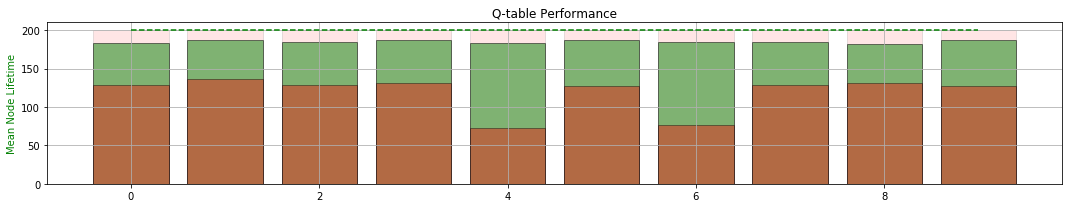

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.495	LOSS : 0.766	LOSS : 0.735	LOSS : 0.827	LOSS : 0.717	LOSS : 0.824	LOSS : 0.790	LOSS : 0.743	LOSS : 0.595	LOSS : 0.624	LOSS : 0.663	LOSS : 0.344	LOSS : 0.720	LOSS : 0.710	LOSS : 0.568	LOSS : 0.527	LOSS : 0.962	LOSS : 0.527	LOSS : 0.719	LOSS : 0.601	LOSS : 0.765	LOSS : 0.583	LOSS : 0.573	LOSS : 0.349	LOSS : 0.806	LOSS : 0.664	LOSS : 0.793	LOSS : 0.461	LOSS : 0.788	LOSS : 0.620	
Validating... MEAN TIME:  121.89
LOSS : 0.715	LOSS : 0.466	LOSS : 0.813	LOSS : 0.842	LOSS : 0.449	LOSS : 0.625	LOSS : 0.595	LOSS : 0.712	LOSS : 0.954	LOSS : 0.743	LOSS : 0.661	LOSS : 0.652	LOSS : 0.591	LOSS : 0.623	LOSS : 0.439	LOSS : 0.640	LOSS : 0.663	LOSS : 0.674	LOSS : 0.718	LOSS : 0.640	LOSS : 0.598	LOSS : 0.647	LOSS : 0.701	LOSS : 0.478	LOSS : 0.759	LOSS : 0.693	LOSS : 0.885	LOSS : 0.641	LOSS : 0.491	LOSS : 0.660	
Validating... MEAN TIME:  162.75
LOSS : 0.779	LOSS : 0.6

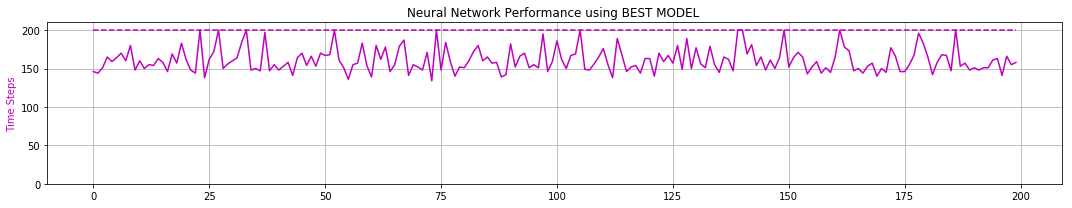

peak memory: 1409.89 MiB, increment: 1015.89 MiB
0 -max- [ 2.400  2.807  0.200  1.840]
0 -min- [-2.385 -2.209 -0.143 -1.860]

1 -max- [ 2.400  2.800  0.198  1.955]
1 -min- [-2.393 -2.228 -0.157 -1.851]

2 -max- [ 2.399  2.746  0.206  1.907]
2 -min- [-2.398 -2.213 -0.150 -1.862]

3 -max- [ 2.398  2.754  0.205  2.094]
3 -min- [-2.399 -2.364 -0.154 -1.666]

4 -max- [ 2.399  2.798  0.209  1.956]
4 -min- [-2.398 -2.222 -0.147 -1.930]

5 -max- [ 2.400  2.839  0.200  2.253]
5 -min- [-2.399 -2.806 -0.205 -1.804]

6 -max- [ 2.399  3.032  0.207  1.956]
6 -min- [-2.385 -2.202 -0.146 -1.914]

7 -max- [ 2.400  2.641  0.205  2.099]
7 -min- [-2.390 -2.222 -0.162 -1.849]

8 -max- [ 2.400  2.787  0.207  2.074]
8 -min- [-2.369 -2.045 -0.137 -1.904]

9 -max- [ 2.399  2.818  0.209  1.957]
9 -min- [-2.399 -2.383 -0.182 -1.879]

Quantization TIME:  0.01 minutes


ITERATION # 12
SMALLEST TIMESTEP in ITERATION 12: 97
REAL TIME TO GENERATE 164532 EXPERIENCES:0:00:04.340710


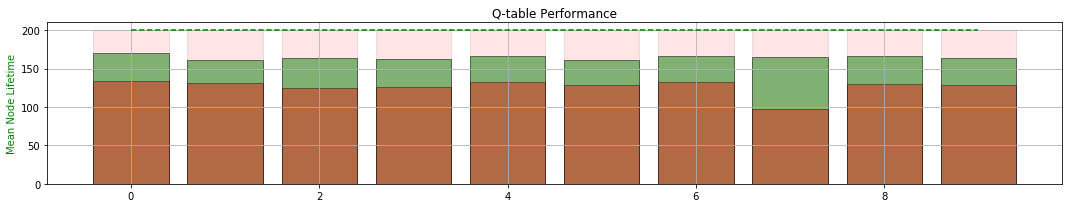

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.708	LOSS : 0.635	LOSS : 0.670	LOSS : 0.668	LOSS : 0.842	LOSS : 0.532	LOSS : 0.561	LOSS : 0.756	LOSS : 0.667	LOSS : 0.891	LOSS : 0.621	LOSS : 0.780	LOSS : 0.476	LOSS : 0.657	LOSS : 0.595	LOSS : 0.480	LOSS : 0.688	LOSS : 0.687	LOSS : 0.486	LOSS : 0.534	LOSS : 0.808	LOSS : 0.520	LOSS : 0.584	LOSS : 0.688	LOSS : 0.722	LOSS : 0.527	LOSS : 0.451	LOSS : 0.497	LOSS : 0.585	LOSS : 0.673	
Validating... MEAN TIME:  116.315
LOSS : 0.655	LOSS : 0.697	LOSS : 0.609	LOSS : 0.762	LOSS : 0.748	LOSS : 0.415	LOSS : 0.553	LOSS : 0.412	LOSS : 0.684	LOSS : 0.552	LOSS : 0.658	LOSS : 0.633	LOSS : 0.587	LOSS : 0.626	LOSS : 0.517	LOSS : 0.734	LOSS : 0.501	LOSS : 0.477	LOSS : 0.444	LOSS : 0.834	LOSS : 0.612	LOSS : 0.850	LOSS : 0.425	LOSS : 0.600	LOSS : 0.483	LOSS : 0.515	LOSS : 0.419	LOSS : 0.773	LOSS : 0.386	LOSS : 0.868	
Validating... MEAN TIME:  122.7
LOSS : 0.518	LOSS : 0.8

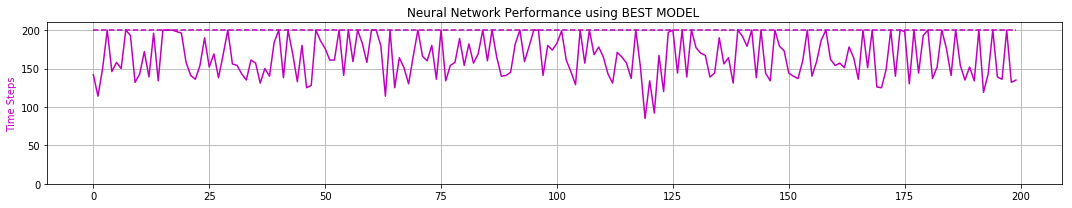

peak memory: 1477.86 MiB, increment: 1000.68 MiB
0 -max- [ 2.387  2.466  0.156  1.349]
0 -min- [-2.399 -2.363 -0.176 -1.317]

1 -max- [ 2.400  2.433  0.161  1.360]
1 -min- [-2.399 -2.425 -0.182 -1.321]

2 -max- [ 2.398  2.062  0.105  1.529]
2 -min- [-2.400 -2.216 -0.178 -1.104]

3 -max- [ 2.393  2.270  0.106  1.328]
3 -min- [-2.400 -2.453 -0.199 -1.352]

4 -max- [ 2.396  2.075  0.108  1.361]
4 -min- [-2.400 -2.261 -0.176 -1.563]

5 -max- [ 2.382  2.100  0.093  1.618]
5 -min- [-2.400 -2.595 -0.198 -1.143]

6 -max- [ 2.376  2.466  0.161  1.358]
6 -min- [-2.400 -2.215 -0.177 -1.289]

7 -max- [ 2.384  2.228  0.141  1.618]
7 -min- [-2.400 -2.404 -0.206 -1.317]

8 -max- [ 2.282  2.643  0.158  1.524]
8 -min- [-2.400 -2.357 -0.177 -1.600]

9 -max- [ 0.852  1.357  0.089  1.666]
9 -min- [-2.400 -2.464 -0.209 -1.170]

Quantization TIME:  0.01 minutes


ITERATION # 13
SMALLEST TIMESTEP in ITERATION 13: 30
REAL TIME TO GENERATE 118395 EXPERIENCES:0:00:02.928320


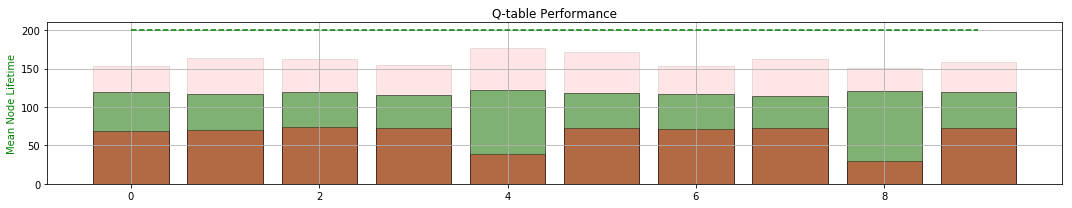

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.917	LOSS : 0.972	LOSS : 0.743	LOSS : 0.502	LOSS : 0.791	LOSS : 0.749	LOSS : 0.899	LOSS : 0.973	LOSS : 0.658	LOSS : 0.966	LOSS : 0.815	LOSS : 0.765	LOSS : 1.071	LOSS : 0.870	LOSS : 1.119	LOSS : 1.382	LOSS : 0.876	LOSS : 1.088	LOSS : 1.237	LOSS : 0.666	LOSS : 0.985	LOSS : 0.860	LOSS : 1.269	LOSS : 1.312	LOSS : 0.952	LOSS : 0.865	LOSS : 1.297	LOSS : 0.749	LOSS : 1.032	LOSS : 1.201	
Validating... MEAN TIME:  123.7
LOSS : 0.692	LOSS : 0.951	LOSS : 1.119	LOSS : 0.765	LOSS : 1.053	LOSS : 0.997	LOSS : 1.004	LOSS : 0.769	LOSS : 0.957	LOSS : 0.934	LOSS : 0.780	LOSS : 0.858	LOSS : 1.140	LOSS : 1.060	LOSS : 0.890	LOSS : 0.817	LOSS : 1.262	LOSS : 0.816	LOSS : 1.194	LOSS : 0.869	LOSS : 0.889	LOSS : 0.916	LOSS : 1.024	LOSS : 0.703	LOSS : 1.029	LOSS : 0.894	LOSS : 0.559	LOSS : 1.096	LOSS : 1.009	LOSS : 1.009	
Validating... MEAN TIME:  195.69
LOSS : 0.888	LOSS : 1.11

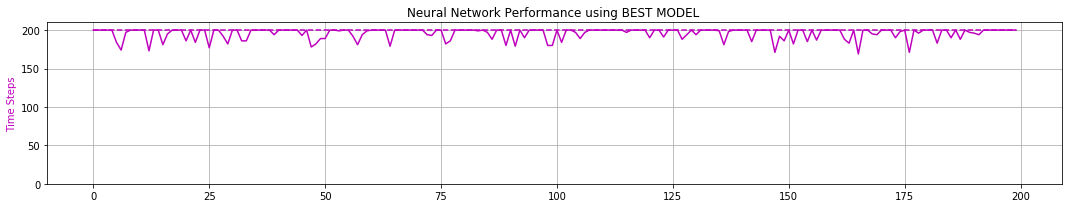

peak memory: 1436.74 MiB, increment: 1034.22 MiB
0 -max- [ 2.399  3.155  0.203  1.654]
0 -min- [-0.161 -1.004 -0.209 -2.285]

1 -max- [ 2.399  3.037  0.169  1.602]
1 -min- [-0.168 -0.943 -0.209 -2.230]

2 -max- [ 2.400  3.041  0.195  1.602]
2 -min- [-0.142 -1.014 -0.209 -2.244]

3 -max- [ 2.400  2.997  0.169  1.782]
3 -min- [-0.165 -1.003 -0.209 -2.221]

4 -max- [ 2.400  3.196  0.205  1.609]
4 -min- [-0.155 -0.941 -0.209 -2.259]

5 -max- [ 2.400  3.024  0.162  1.513]
5 -min- [-0.155 -0.993 -0.209 -2.226]

6 -max- [ 2.400  3.347  0.191  1.806]
6 -min- [-0.158 -0.991 -0.209 -2.221]

7 -max- [ 2.399  2.981  0.165  1.862]
7 -min- [-0.164 -0.984 -0.209 -2.262]

8 -max- [ 2.400  3.146  0.208  1.869]
8 -min- [-0.164 -1.006 -0.209 -2.249]

9 -max- [ 2.400  2.980  0.163  1.797]
9 -min- [-0.147 -0.826 -0.209 -2.283]

Quantization TIME:  0.01 minutes


ITERATION # 14
SMALLEST TIMESTEP in ITERATION 14: 11
REAL TIME TO GENERATE 183767 EXPERIENCES:0:00:05.602125


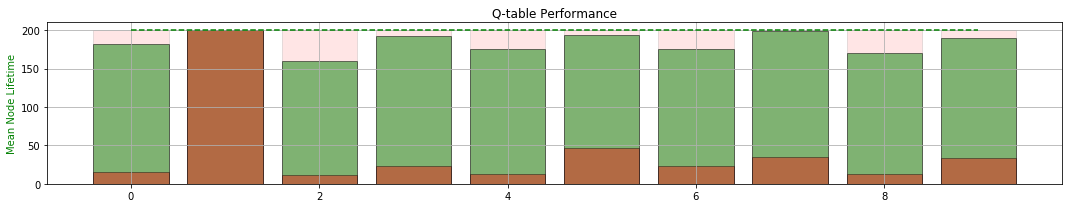

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.943	LOSS : 0.831	LOSS : 0.994	LOSS : 0.608	LOSS : 0.847	LOSS : 0.789	LOSS : 0.485	LOSS : 0.903	LOSS : 1.028	LOSS : 0.847	LOSS : 0.868	LOSS : 0.847	LOSS : 0.833	LOSS : 0.888	LOSS : 0.787	LOSS : 0.733	LOSS : 1.063	LOSS : 0.872	LOSS : 0.662	LOSS : 0.628	LOSS : 0.677	LOSS : 1.345	LOSS : 0.712	LOSS : 0.932	LOSS : 0.805	LOSS : 0.938	LOSS : 0.752	LOSS : 0.961	LOSS : 0.964	LOSS : 0.928	
Validating... MEAN TIME:  149.165
LOSS : 0.703	LOSS : 0.977	LOSS : 0.919	LOSS : 1.002	LOSS : 0.757	LOSS : 0.908	LOSS : 0.696	LOSS : 0.771	LOSS : 0.771	LOSS : 0.558	LOSS : 0.719	LOSS : 0.804	LOSS : 1.031	LOSS : 0.608	LOSS : 0.946	LOSS : 0.654	LOSS : 0.795	LOSS : 0.694	LOSS : 0.833	LOSS : 0.782	LOSS : 0.858	LOSS : 0.698	LOSS : 0.993	LOSS : 1.082	LOSS : 0.856	LOSS : 0.894	LOSS : 0.757	LOSS : 1.028	LOSS : 0.966	LOSS : 1.053	
Validating... MEAN TIME:  133.365
LOSS : 0.810	LOSS : 1

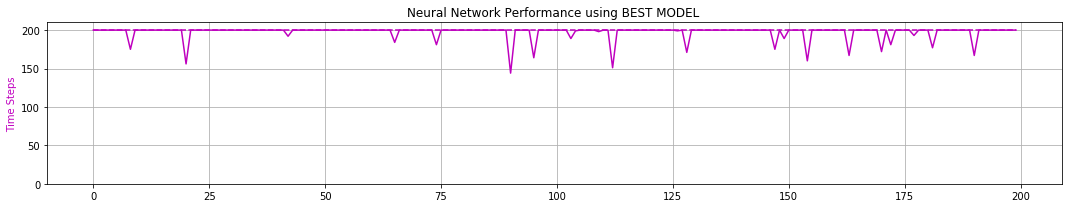

peak memory: 1430.27 MiB, increment: 1020.60 MiB
0 -max- [ 2.386  2.278  0.209  2.114]
0 -min- [-0.219 -1.399 -0.127 -1.959]

1 -max- [ 1.718  1.920  0.202  2.222]
1 -min- [-0.646 -2.104 -0.207 -2.089]

2 -max- [ 2.396  2.255  0.209  2.304]
2 -min- [-0.280 -1.571 -0.145 -1.943]

3 -max- [ 1.659  2.136  0.208  2.284]
3 -min- [-1.042 -1.943 -0.208 -2.106]

4 -max- [ 2.398  2.258  0.209  2.186]
4 -min- [-0.197 -1.414 -0.142 -1.955]

5 -max- [ 1.652  2.132  0.207  2.267]
5 -min- [-1.383 -2.083 -0.204 -2.156]

6 -max- [ 2.394  2.262  0.209  2.417]
6 -min- [-0.197 -1.415 -0.146 -1.989]

7 -max- [ 2.036  1.922  0.209  2.256]
7 -min- [-2.091 -2.469 -0.206 -2.094]

8 -max- [ 2.282  2.131  0.209  2.234]
8 -min- [-0.221 -1.586 -0.155 -1.966]

9 -max- [ 1.641  2.119  0.207  2.260]
9 -min- [-0.446 -1.755 -0.208 -2.217]

Quantization TIME:  0.01 minutes


ITERATION # 15
SMALLEST TIMESTEP in ITERATION 15: 87
REAL TIME TO GENERATE 192838 EXPERIENCES:0:00:06.142182


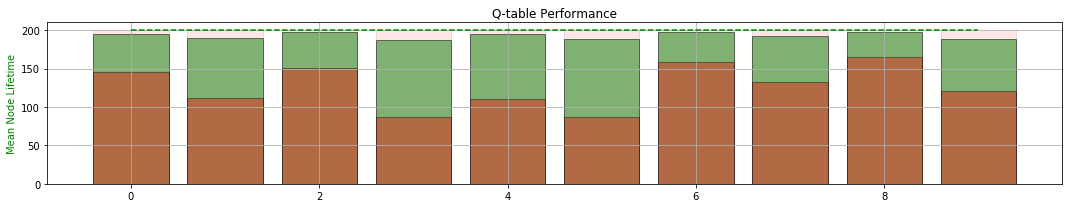

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.547	LOSS : 0.416	LOSS : 0.697	LOSS : 0.761	LOSS : 0.613	LOSS : 0.453	LOSS : 0.408	LOSS : 0.603	LOSS : 0.367	LOSS : 0.499	LOSS : 0.379	LOSS : 0.537	LOSS : 0.449	LOSS : 0.455	LOSS : 0.629	LOSS : 0.546	LOSS : 0.604	LOSS : 0.510	LOSS : 0.354	LOSS : 0.646	LOSS : 0.356	LOSS : 0.507	LOSS : 0.519	LOSS : 0.535	LOSS : 0.576	LOSS : 0.505	LOSS : 0.553	LOSS : 0.616	LOSS : 0.453	LOSS : 0.470	
Validating... MEAN TIME:  141.43
LOSS : 0.555	LOSS : 0.431	LOSS : 0.523	LOSS : 0.464	LOSS : 0.554	LOSS : 0.220	LOSS : 0.460	LOSS : 0.337	LOSS : 0.563	LOSS : 0.317	LOSS : 0.385	LOSS : 0.413	LOSS : 0.452	LOSS : 0.433	LOSS : 0.365	LOSS : 0.343	LOSS : 0.433	LOSS : 0.580	LOSS : 0.485	LOSS : 0.562	LOSS : 0.435	LOSS : 0.523	LOSS : 0.338	LOSS : 0.563	LOSS : 0.565	LOSS : 0.377	LOSS : 0.514	LOSS : 0.507	LOSS : 0.561	LOSS : 0.500	
Validating... MEAN TIME:  200.0
LOSS : 0.437	LOSS : 0.53

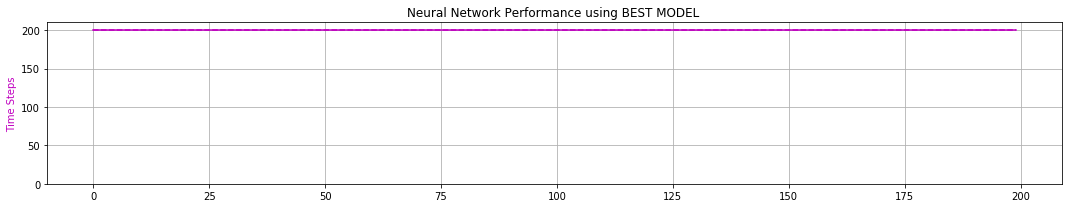

peak memory: 1523.66 MiB, increment: 1016.60 MiB
0 -max- [ 0.804  1.582  0.160  2.140]
0 -min- [-2.399 -2.372 -0.191 -1.804]

1 -max- [ 0.808  1.718  0.168  2.137]
1 -min- [-2.399 -2.373 -0.209 -1.950]

2 -max- [ 0.812  1.687  0.205  2.200]
2 -min- [-2.389 -2.409 -0.204 -1.876]

3 -max- [ 0.836  1.576  0.171  2.211]
3 -min- [-2.398 -2.457 -0.209 -1.779]

4 -max- [ 0.940  1.893  0.208  2.413]
4 -min- [-2.399 -2.433 -0.205 -1.910]

5 -max- [ 0.623  1.372  0.142  2.103]
5 -min- [-2.398 -2.408 -0.208 -1.932]

6 -max- [ 0.897  1.716  0.209  2.233]
6 -min- [-2.399 -2.368 -0.194 -1.902]

7 -max- [ 0.745  1.710  0.175  2.110]
7 -min- [-2.399 -2.659 -0.209 -2.052]

8 -max- [ 0.765  1.722  0.205  2.240]
8 -min- [-2.399 -2.277 -0.209 -1.951]

9 -max- [ 0.650  1.692  0.182  2.081]
9 -min- [-2.399 -2.414 -0.209 -1.928]

Quantization TIME:  0.01 minutes


ITERATION # 16
SMALLEST TIMESTEP in ITERATION 16: 15
REAL TIME TO GENERATE 158331 EXPERIENCES:0:00:04.367108


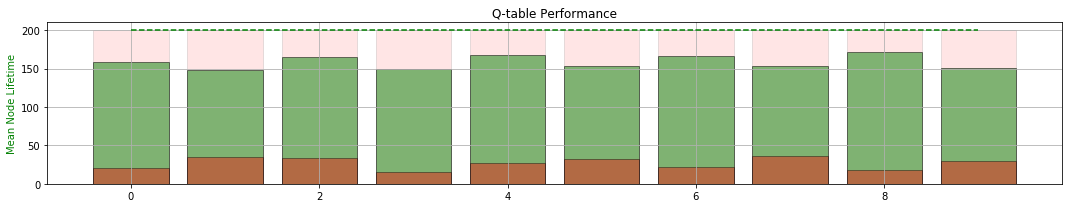

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.565	LOSS : 0.702	LOSS : 0.926	LOSS : 0.710	LOSS : 0.876	LOSS : 0.425	LOSS : 0.419	LOSS : 0.848	LOSS : 0.622	LOSS : 0.764	LOSS : 0.646	LOSS : 0.786	LOSS : 0.601	LOSS : 0.612	LOSS : 0.668	LOSS : 0.627	LOSS : 0.684	LOSS : 0.740	LOSS : 0.617	LOSS : 1.059	LOSS : 0.923	LOSS : 0.974	LOSS : 0.625	LOSS : 0.525	LOSS : 0.599	LOSS : 0.678	LOSS : 0.708	LOSS : 0.829	LOSS : 0.572	LOSS : 0.824	
Validating... 

KeyboardInterrupt: 

Process ForkPoolWorker-36:
Process ForkPoolWorker-31:
Process ForkPoolWorker-32:
Process ForkPoolWorker-28:
Process ForkPoolWorker-35:
Process ForkPoolWorker-30:
Process ForkPoolWorker-29:
Process ForkPoolWorker-37:
Process ForkPoolWorker-33:
Process ForkPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [ ]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

In [ ]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [ ]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))